In [0]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#from keras import metrics, models, layers, optimizers, Sequential
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

In [0]:
import random as rn
import numpy as np

np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)

In [0]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv.layers:
    layer.trainable = True 
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f850afbff98> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f850b074f98> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f850b074e10> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f850afd4710> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f850b0e64a8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f850b074f28> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f850af69828> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f850af64940> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8507a04390> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f850af72c18> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f850af809e8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f850af72

In [0]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
]

def make_model(metrics = METRICS, output_bias=None):
 
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
    
  model = keras.Sequential()
  model.add(vgg_conv)
  model.add(keras.layers.Flatten())
  #model.add(keras.layers.Dense(1024, activation='relu'))
  #model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(1024, activation='relu'))
  #model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-5),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  
  return model

In [0]:
pos = 173
neg = 727
initial_bias = np.log([pos/neg])
print(initial_bias)


[-1.43563488]


In [0]:
model = make_model(output_bias=initial_bias)
model.save_weights('initial_weights_1fc.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 25,692,161
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 64
val_batchsize = 134
train_generator = train_datagen.flow_from_directory(
        directory="/content/Dataset/train2",
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='binary', 
        shuffle=True,
        seed=42)

validation_generator = validation_datagen.flow_from_directory(
        directory="/content/Dataset/valid2",
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='binary',
        shuffle=False, 
        seed=42)


Found 766 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [0]:
pos = 173
neg = 727
total = 900
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
print(weight_for_0)
print(weight_for_1) 
class_weight = {0: weight_for_0, 1: weight_for_1}

0.6189821182943603
2.6011560693641615


In [0]:
model = make_model()
# Train the model
model.load_weights('initial_weights_1fc.h5')

checkpoint = tf.keras.callbacks.ModelCheckpoint('tuning_all_1fc_nodrop_{epoch:04d}.h5', monitor='val_precision', verbose=1, save_best_only=True,  mode='max', save_freq='epoch')
early = tf.keras.callbacks.EarlyStopping(monitor='val_precision', patience=40, verbose=1, mode='max')
history = model.fit(
      train_generator,
      epochs=100,
      class_weight=class_weight,
      validation_data=validation_generator,
      callbacks=[checkpoint,early],
      verbose=1, 
      use_multiprocessing=False,
      max_queue_size=10,                # maximum size for the generator queue
      workers=1,  
      )


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.5326 - precision: 0.2245 - recall: 0.5850 - auc: 0.5612 - tp: 86.0000 - fp: 297.0000
Epoch 00001: val_precision improved from -inf to 0.21622, saving model to tuning_all_1fc_nodrop_0001.h5
12/12 [==============================] - 62s 5s/step - loss: 0.7085 - accuracy: 0.5326 - precision: 0.2245 - recall: 0.5850 - auc: 0.5612 - tp: 86.0000 - fp: 297.0000 - val_loss: 0.6341 - val_accuracy: 0.6493 - val_precision: 0.2162 - val_recall: 0.3077 - val_auc: 0.6335 - val_tp: 8.0000 - val_fp: 29.0000
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.6410 - precision: 0.3037 - recall: 0.6735 - auc: 0.7285 - tp: 99.0000 - fp: 227.0000
Epoch 00002: val_precision improved from 0.21622 to 0.30000, saving model to tuning_all_1fc_nodrop_0002.h5
12/12 [==============================] - 60s 5s/step - loss: 0.6159 - accuracy: 0.6410 - precision: 0.3037 - recall: 0.6735 - auc: 0

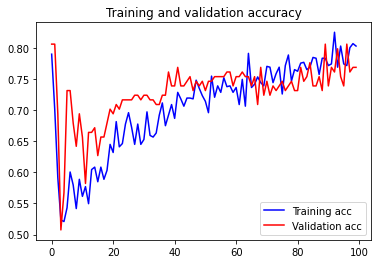

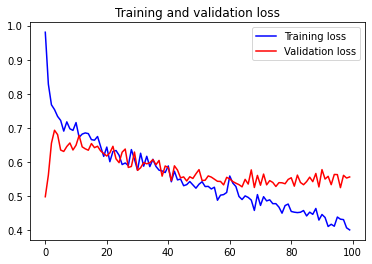

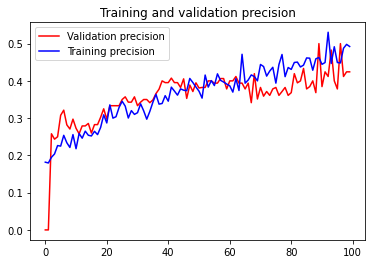

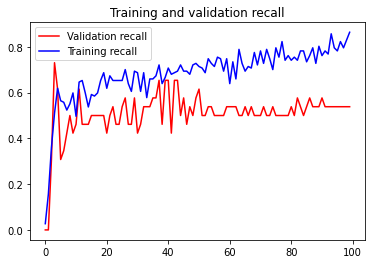

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_precision = history.history['val_precision']
precision = history.history['precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.plot(epochs, precision, 'b', label='Training precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.plot(epochs, recall, 'b', label='Training recall')
plt.title('Training and validation recall')
plt.legend()

plt.show()

In [0]:
tsdata = ImageDataGenerator(rescale=1./255)
test_generator = tsdata.flow_from_directory(directory="/content/Dataset/test", target_size=(224,224), class_mode='binary',shuffle=False, batch_size=1, seed=42)

#model = load_model('test0002.h5')
model.load_weights('/content/tuning_1fc_0031.h5')

results = model.evaluate(test_generator)

print(results)

Found 379 images belonging to 2 classes.
379/379 [==============================] - 23s 60ms/step - loss: 0.4863 - accuracy: 0.7942 - precision: 0.4810 - recall: 0.5067 - auc: 0.7549 - tp: 38.0000 - fp: 41.0000
[0.48629623651504517, 0.7941952347755432, 0.4810126721858978, 0.5066666603088379, 0.7548684477806091, 38.0, 41.0]


In [0]:
!rm -rf /content/Dataset/a

In [0]:
!cp -r /content/drive/My\ Drive/VCOM/Dataset/valid2 /content/Dataset

In [0]:
!cp -r /content/drive/My\ Drive/VCOM/Dataset/train2 /content/Dataset

In [0]:
!cp -r /content/tuning_all_1fc_0016.h5 /content/drive/My\ Drive/VCOM